In [10]:
import netCDF4
import numpy as np
import datetime as dt
import pandas as pd
import glob
import matplotlib.pyplot as plt
from scipy.stats import moment

import warnings
warnings.filterwarnings('ignore')

In [11]:
spec_path = '/gws/nopw/j04/ncas_radar_vol2/data/ICECAPSarchive/mmcr/spc_unzip/'


In [12]:
# pick date and hours, added ability to load specifc hours to speed data loading.

start_date = dt.datetime(2019,7,11,5)
stop_date = dt.datetime(2019,7,11,8)

# Function to making appending data files easier:
flatten = lambda l: [item for sublist in l for item in sublist]

all_files = []

f_date_list = pd.date_range(start_date,stop_date,freq='H')
for date in f_date_list:
    day_of_year = (date.date()).timetuple().tm_yday
    all_files.append(glob.glob(spec_path+ '%s'%dt.datetime.strftime(date,format='%Y')+str(day_of_year)+ '%s'%dt.datetime.strftime(date,format='%H')+'*MMCRSpecMom.nc'))
    print('%s'%dt.datetime.strftime(date,format='%Y')+str(day_of_year)+ '%s'%dt.datetime.strftime(date,format='%H')+'*MMCRSpecMom.nc')
all_files = flatten(all_files)
all_files.sort()

# Extract data
mmcr_spec_nc = netCDF4.MFDataset(all_files,'r')

mode = 3

# Get heights for particular mode
# Range Heights (center of radar sample volume), magl.
# (mode, heights)
Heights = mmcr_spec_nc.variables['Heights'][mode,:]
#Heights = Heights[Heights.mask == False]

# Get mode/ time
ModeNum = mmcr_spec_nc.variables['ModeNum'][:]

# Get data quality status and subset for modes
DataQualityStatus = mmcr_spec_nc.variables['DataQualityStatus'][:]
DataQualityStatus = DataQualityStatus[np.where(ModeNum==mode)]

# Get Signal to Noise ratio
# dB, (time, heights)
# Remove signal to noise ratio < -14
SignalToNoiseRatio = mmcr_spec_nc.variables['SignalToNoiseRatio'][:,:]
SignalToNoiseRatio = SignalToNoiseRatio[np.where(ModeNum==mode)]

# Get reflectivity and subset for mode and heights. Remove bad s2n. 
# Reflectiity, dBZ (time, heights)
Reflectivity = mmcr_spec_nc.variables['Reflectivity'][:,:]
Reflectivity = Reflectivity[np.where(ModeNum==mode)]
#Reflectivity = np.ma.masked_where(SignalToNoiseRatio<-14,Reflectivity) 

#Get Noise Level # nothing in avg Noise
# Noise level, dB (time, heights) Remove bad s2n. 
NoiseLevel = mmcr_spec_nc.variables['NoiseLevel'][:]
NoiseLevel = mmcr_spec_nc.variables['NoiseLevel'][np.where(ModeNum==mode)]
#NoiseLevel = np.ma.masked_where(SignalToNoiseRatio<-14,NoiseLevel) 

# Get RangeCorrectedPower and subset for mode and heights. Remove bad s2n. 
# RangeCorrectedPower, dBm milliwatt decibels (time, heights)
RangeCorrectedPower = mmcr_spec_nc.variables['RangeCorrectedPower'][:,:]
RangeCorrectedPower = RangeCorrectedPower[np.where(ModeNum==mode)]
RangeCorrectedPower = np.ma.masked_where(SignalToNoiseRatio<-14,RangeCorrectedPower) 

# get spectral width 
spec_width = mmcr_spec_nc.variables['SpectralWidth'][:,:]
spec_width = spec_width[np.where(ModeNum==mode)]
spec_width = np.ma.masked_where(SignalToNoiseRatio<-14,spec_width)

# dopplar velocity 
dv = mmcr_spec_nc.variables['MeanDopplerVelocity'][:,:]
dv = dv[np.where(ModeNum==mode)]
dv = np.ma.masked_where(SignalToNoiseRatio<-14,dv)

#Get Spectra
spectra = mmcr_spec_nc.variables['Spectra'][:,:,0:mmcr_spec_nc.variables['NumFFT'][mode].data]
spectra = spectra[np.where(ModeNum==mode)]


# Get times: #Do last not to confuse big load of other data. This has to be done this way to deal with offset times in each file.
for i in range(0, len(all_files)):
    mmcr_temp = netCDF4.Dataset(all_files[i],'r')
    # Get mode/ time
    ModeNum_temp = mmcr_temp.variables['ModeNum'][:]    
    base_time = pd.to_datetime(mmcr_temp.variables['base_time'][:],origin='unix',unit='s')
    temp_times = pd.to_datetime(mmcr_temp.variables['time_offset'][:],origin=base_time,unit='s')
    # Subset times for mode
    temp_times = temp_times[np.where(ModeNum_temp==mode)]        
    if i==0:
        all_times = temp_times
    else:
        all_times = np.append(all_times,temp_times)



print('Done Loading Data')


201919205*MMCRSpecMom.nc
201919206*MMCRSpecMom.nc
201919207*MMCRSpecMom.nc
201919208*MMCRSpecMom.nc
Done Loading Data


float32 Spectra('time', 'heights', 'speclength')
     long_name: Spectra Dat
     units: count
     missing_value: 9.9692099683868690e+36
 unlimited dimensions = ('time',)
 current size = (2233, 234, 256)}

In [13]:
print('Spectra Shape ' + str(np.shape(spectra)))
print('Mode Length ' + str(np.shape(np.where(ModeNum==mode))))
print('Moment Shape ' + str(np.shape(Reflectivity)))
print ('Time Shape ' + str(np.shape(all_times)))
print('Height Shape ' + str(np.shape(Heights)))

Spectra Shape (1116, 234, 128)
Mode Length (1, 1116)
Moment Shape (1116, 234)
Time Shape (1116,)
Height Shape (234,)


Time is 2019-07-11T05:00:22.497999872 UTC
Height is 4410.1885 m
Reflectivity is -20.0989 dBZ
Mean Doppler Velocity is 0.33020493 m/s
Spectral Width is 0.16691293 m/s
NoiseLevel is 43.65993
SkyNoiseLevel is 44.243103
RangeCorrectedPower is -28.716621 dBm
Delta v is 0.04868724197149277 m/s
Calced Z is -21.420076847076416
Z calced from specta -21.4200777412452
Reported Z/Calc Z 0.9383206225075637


(-1.4, 0.2)

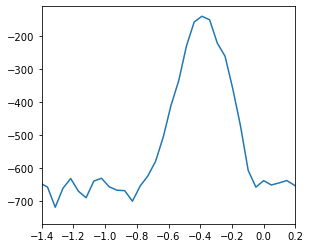

In [5]:
t = 1
h = 50
print('Time is ' + str(all_times[t]) + ' UTC')
print('Height is ' + str(Heights[h]) + ' m')
print('Reflectivity is ' + str(Reflectivity[t,h]) + ' dBZ')
print('Mean Doppler Velocity is ' + str(dv[t,h]) + ' m/s')
print('Spectral Width is ' + str(spec_width[t,h]) + ' m/s')
print('NoiseLevel is ' + str(NoiseLevel[t,h]))
print('SkyNoiseLevel is ' + str(mmcr_spec_nc.variables['SkyNoiseLevel'][mode]))
print('RangeCorrectedPower is ' + str(RangeCorrectedPower[t,h]) + ' dBm')
# spectra in units of count; noise is 10^5 and signal is 10^8
# Zsp(v) = Z(v)/ delta v with Doppler spectrum grid length
# delta v is 2x NyquistV / Number of fft points (lenght of spectra) ; 2*mmcr_spec_nc.variables['NyquistVelocity'][mode]/mmcr_spec_nc.variables['NumFFT'][mode].data
# 0.04868724197149277
# CalibrationConstant is First Order Estimate of Spectral Count Calibration; units: ADC/dBZ
# 176.3725

delta_v=2*mmcr_spec_nc.variables['NyquistVelocity'][mode]/mmcr_spec_nc.variables['NumFFT'][mode].data

print('Delta v is ' + str(delta_v) + ' m/s')

cal_constant = mmcr_spec_nc.variables['CalibrationConstant'][mode]
rad_constant = mmcr_spec_nc.variables['RadarConstant'][mode]
noise_spectral = 10*np.log10(10**(NoiseLevel[t,h]/10)/128)

spectra_dbz=(10*np.log10(spectra[t,h,:]/(cal_constant*rad_constant*128))-noise_spectral)/delta_v
#Z_spectra_calc=np.sum(spectra_dbz*delta_v

#print('Calced Z from spectrum dBZ ' + str())

Z_calc=10*np.log10(np.sum(spectra[t,h,:]/(cal_constant*rad_constant)/128))-NoiseLevel[t,h]
print('Calced Z is ' + str(Z_calc))

Z_spectral_calc=10*np.log10(np.sum(10**((spectra_dbz*delta_v)/10))/128)
print('Z calced from specta ' + str(Z_spectral_calc))

Z_ratio=Reflectivity[t,h]/Z_calc

print('Reported Z/Calc Z ' +str(Z_ratio))
vel_spec_range=np.arange(-1*mmcr_spec_nc.variables['NyquistVelocity'][mode],mmcr_spec_nc.variables['NyquistVelocity'][mode],2*mmcr_spec_nc.variables['NyquistVelocity'][mode]/mmcr_spec_nc.variables['NumFFT'][mode].data)

#Flipped spectra so negative velocity is down
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(121)
ax1.plot(vel_spec_range,np.flip(spectra_dbz,0))
ax1.set_xlim(-1.4,0.2)




In [6]:
print(mmcr_spec_nc.variables['RadarConstant'][mode])
print(mmcr_spec_nc.variables['CalibrationConstant'][mode])
print(mmcr_spec_nc.variables['NumCoherentIntegrations'][mode])
print(mmcr_spec_nc.variables['NumSpectralAverages'][mode])

print(mmcr_spec_nc.variables['SkyNoiseLevel'][mode])
print(2*mmcr_spec_nc.variables['NyquistVelocity'][mode]/mmcr_spec_nc.variables['NumFFT'][mode].data)


8.6177225
176.3725
6
10
44.243103
0.04868724197149277


In [7]:
mmcr_spec_nc.variables['RadarConstant'][3]

masked_array(data=8.6177225,
             mask=False,
       fill_value=1e+20,
            dtype=float32)

In [8]:
mmcr_spec_nc.variables

{'base_time': <class 'netCDF4._netCDF4.Variable'>
 int32 base_time()
     string: 11-Jul-2019,05:00:01 GMT
     long_name: Base Time in Epoch
     units: seconds since 1970-1-1 0:00:00 0:00
 unlimited dimensions: 
 current shape = ()
 filling on, default _FillValue of -2147483647 used,
 'time_offset': <class 'netCDF4._netCDF4._Variable'>
 float64 time_offset('time',)
     long_name: Time offset from base_time
     units: seconds since 2019-07-11 05:00:01 0:00
 unlimited dimensions = ('time',)
 current size = (8940,),
 'ModeDescription': <class 'netCDF4._netCDF4.Variable'>
 |S1 ModeDescription(mode, namelength)
     long_name: radar mode char identifier
     missing_value: 0
 unlimited dimensions: 
 current shape = (10, 32)
 filling on, default _FillValue of   used,
 'RxCalTimeStamp': <class 'netCDF4._netCDF4.Variable'>
 int32 RxCalTimeStamp(mode)
     long_name: Receiver Cal Time Stamp
     units: s
     missing_value: -2147483647
 unlimited dimensions: 
 current shape = (10,)
 filling

10